In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar o DataFrame
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean.xlsx')

# Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

# 3. Contar o número de rastreios por semana
week_screenings = df.resample('W-Mon', on='Screening_date').size()

# 4. Criar um DataFrame com a nova variável
df_week = week_screenings.reset_index()
df_week.columns = ['Semana', 'week_screenings']

# Remover as linhas onde week_screenings é igual a 0
df_week = df_week[df_week['week_screenings'] != 0]

# Exibir o resultado
print(df_week)

        Semana  week_screenings
0   2022-03-07               92
2   2022-03-21               62
3   2022-03-28               90
4   2022-04-04               69
5   2022-04-11               70
..         ...              ...
107 2024-03-25              168
108 2024-04-01              198
109 2024-04-08              242
111 2024-04-22              186
112 2024-04-29              184

[76 rows x 2 columns]


# ANÁLISE WEEK_SCREENINGS

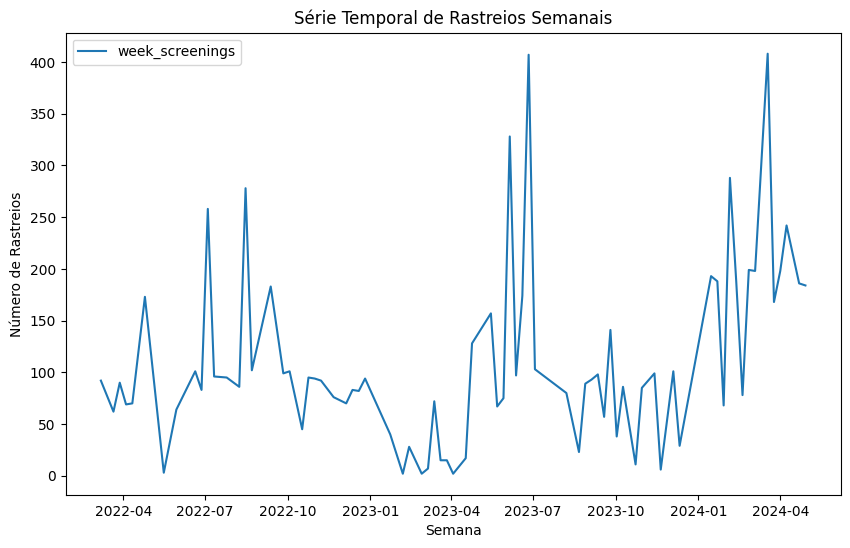

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_week['Semana'], df_week['week_screenings'], label='week_screenings')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Série Temporal de Rastreios Semanais')
plt.legend()
plt.show()

Estatísticas Descritivas

In [3]:
print(df_week['week_screenings'].describe())

count     76.000000
mean     110.447368
std       86.917186
min        2.000000
25%       66.250000
50%       92.000000
75%      159.750000
max      408.000000
Name: week_screenings, dtype: float64


Dispersão e Variedade: O desvio padrão relativamente alto (86.92) em comparação com a média (110.45) indica que há uma ampla dispersão nos dados.

Assimetria e Distribuição: A diferença entre a mediana (92) e a média (110.45) sugere que a distribuição pode ser assimétrica, possivelmente com uma cauda à direita mais longa (distribuição positiva). Isso é reforçado pelo fato de que o 75º percentil (159.75) está bastante distante da mediana (92) e do 25º percentil (66.25).

Faixa de Dados: A diferença entre o mínimo (2) e o máximo (408) também sugere uma grande variação nos valores.

Estacionariedade

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_week['week_screenings'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.477427909874423
p-value: 0.1210633928076909


Com um valor-p de 0.1211, que é maior que 0.05, você não rejeita a hipótese nula. Isso sugere que há uma evidência insuficiente para afirmar que a série temporal é estacionária. Em outras palavras, a série pode ser não estacionária.

Tornar a série estacionária

In [17]:
# Definir a série temporal
series = df_week['week_screenings']

# Aplicar a diferenciação de ordem 1 e adicionar a nova coluna
df_week['week_screenings_diff'] = series.diff()

# Remover a coluna original 'week_screenings'
df_week.drop(columns=['week_screenings'], inplace=True)

# Remover linhas com NaN, se necessário (por exemplo, a primeira linha após a diferenciação)
df_week.dropna(subset=['week_screenings_diff'], inplace=True)

print(df_week)

        Semana  week_screenings_diff
2   2022-03-21                 -30.0
3   2022-03-28                  28.0
4   2022-04-04                 -21.0
5   2022-04-11                   1.0
7   2022-04-25                 103.0
..         ...                   ...
107 2024-03-25                -240.0
108 2024-04-01                  30.0
109 2024-04-08                  44.0
111 2024-04-22                 -56.0
112 2024-04-29                  -2.0

[75 rows x 2 columns]


In [18]:
# Renomear a coluna 'week_screenings_diff' para 'week_screenings'
df_week.rename(columns={'week_screenings_diff': 'week_screenings'}, inplace=True)

In [7]:
df_week.columns

Index(['Semana', 'week_screenings'], dtype='object')

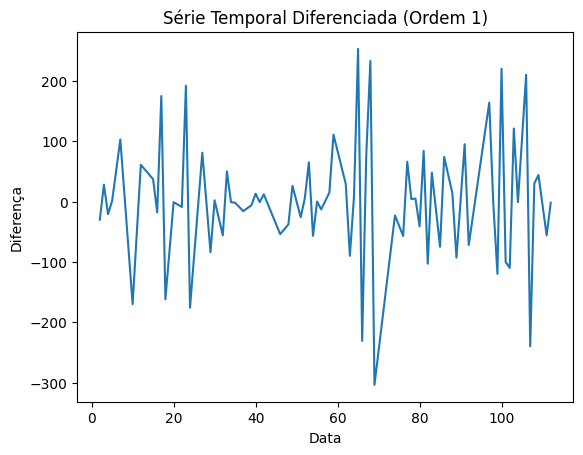

In [8]:
import matplotlib.pyplot as plt

# Visualizar a série temporal diferenciada
df_week['week_screenings'].plot(title='Série Temporal Diferenciada (Ordem 1)')
plt.xlabel('Data')
plt.ylabel('Diferença')
plt.show()

In [9]:
print(df_week)

        Semana  week_screenings
2   2022-03-21            -30.0
3   2022-03-28             28.0
4   2022-04-04            -21.0
5   2022-04-11              1.0
7   2022-04-25            103.0
..         ...              ...
107 2024-03-25           -240.0
108 2024-04-01             30.0
109 2024-04-08             44.0
111 2024-04-22            -56.0
112 2024-04-29             -2.0

[75 rows x 2 columns]


Decomposição da série temporal

In [10]:
df_week.columns

Index(['Semana', 'week_screenings'], dtype='object')

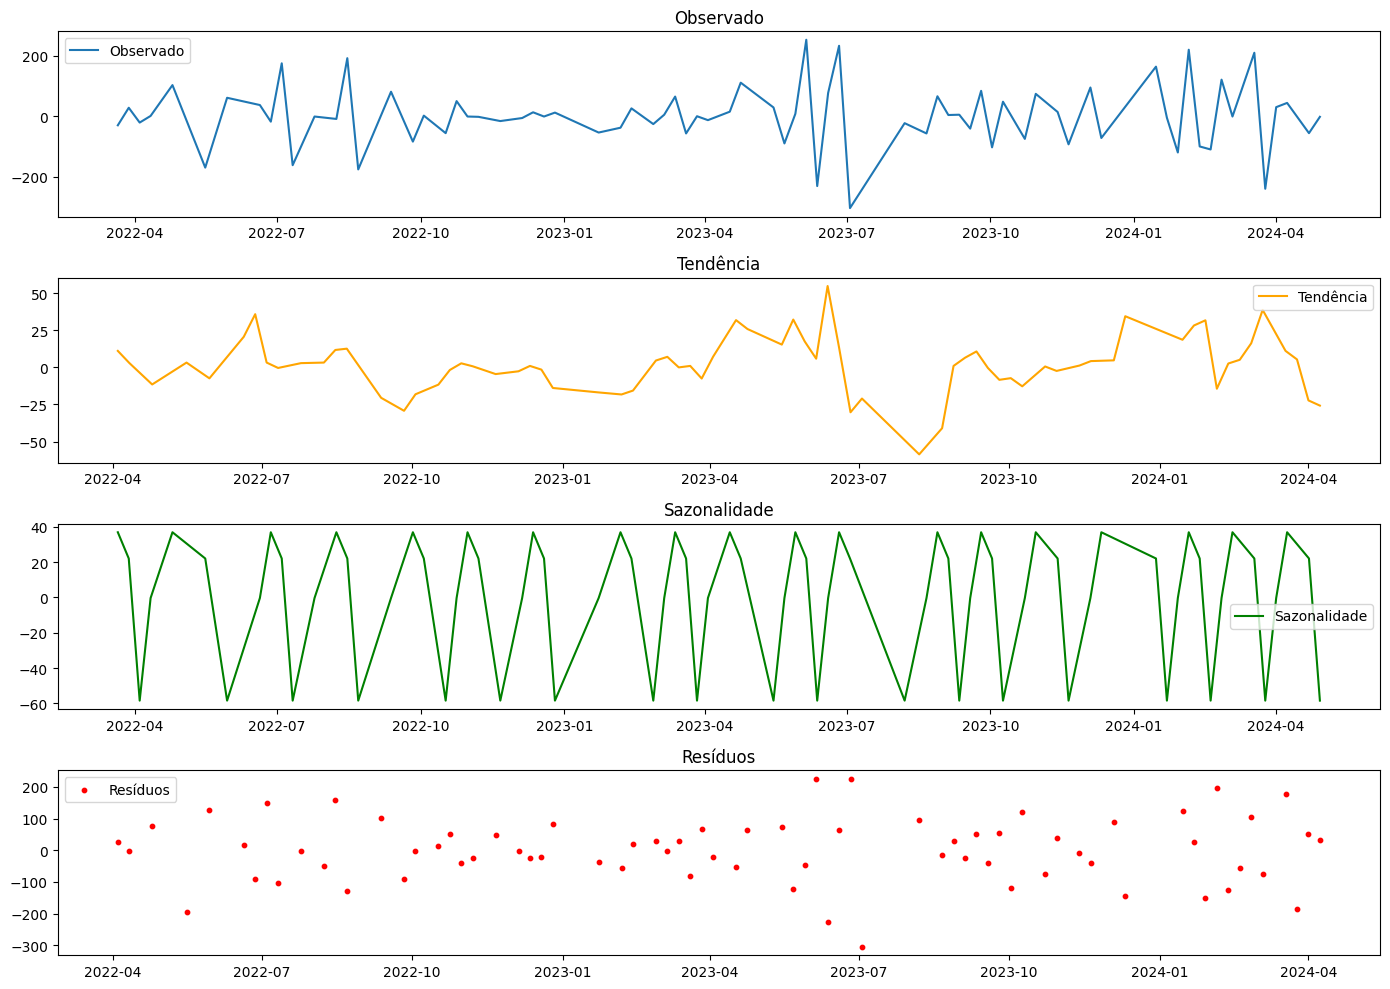

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Definir a série temporal com a frequência correta (semana)
df_week.set_index('Semana', inplace=True)
series = df_week['week_screenings']

# Aplicar a decomposição
decomposition = seasonal_decompose(series, model='additive', period=4)  # period=52 para dados semanais

# Plotar a decomposição
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observado')
plt.title('Observado')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendência', color='orange')
plt.title('Tendência')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
plt.title('Sazonalidade')
plt.legend()

# Gráfico dos Resíduos como pontos
plt.subplot(4, 1, 4)
plt.scatter(decomposition.resid.index, decomposition.resid, label='Resíduos', color='red', s=10)  # s é o tamanho dos pontos
plt.title('Resíduos')
plt.legend()

plt.tight_layout()
plt.show()


Série Original (week_screenings): Mostra a série temporal dos rastreios semanais, com flutuações significativas e alguns picos marcantes.

Sazonalidade (Seasonal): A componente sazonal revela um padrão sazonal com variações recorrentes fortes. Isso pode significar que há uma sazonalidade pequena.

Resíduos (Resid): Os resíduos mostram o que resta após a remoção da tendência e sazonalidade. A maior parte dos resíduos parece estar centrada em torno de zero, o que é bom, mas há alguns pontos fora da linha que podem indicar outliers.

Autocorrelação e Parcial Autocorrelação

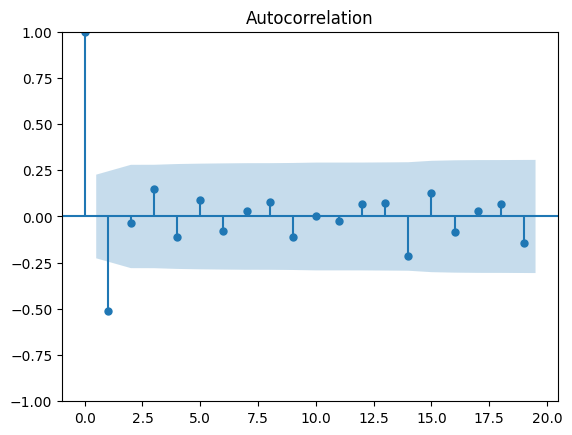

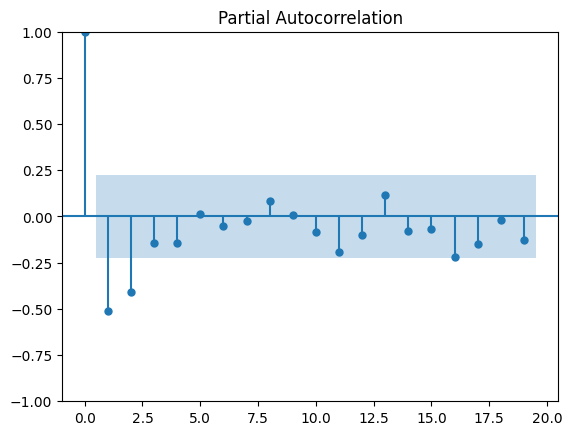

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_week['week_screenings'])
plot_pacf(df_week['week_screenings'])
plt.show()

# MODELO AR

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and

Modelo: AR(1)
MAE: 95.60210898638107
MSE: 15349.789775704301
RMSE: 123.89426853452221
R2: 0.036074487229687535
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


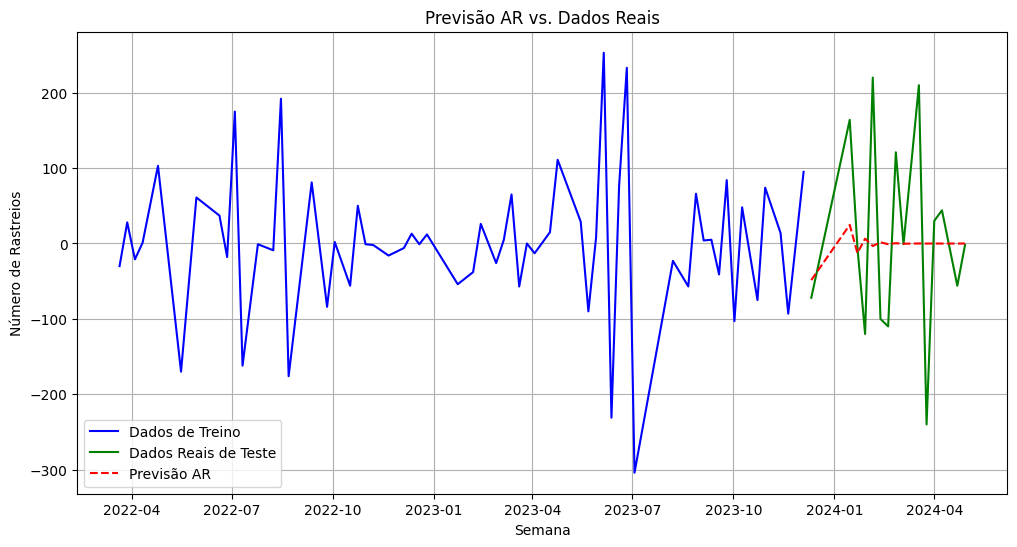

In [20]:
# # 1. Dividir os dados em treino (antes de 2024) e teste (2024)
# train = df_week[df_week['Semana'] < '2024-01-01']
# y_train = train['week_screenings']
# test = df_week[df_week['Semana'] >= '2024-01-01']
# y_test = test['week_screenings']

# 1. Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# # 2. Criar e ajustar o modelo AR
# model = AutoReg(train['week_screenings'], lags=1)  # lags=1 para um modelo AR(1)
# model_fit = model.fit()

# 2. Criar e ajustar o modelo AR
model = AutoReg(y_train, lags=1)  # lags=1 para um modelo AR(1)
model_fit = model.fit()

# 3. Fazer previsões
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: AR(1)")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# # 5. Plotar os resultados split date
# plt.figure(figsize=(12, 6))
# plt.plot(test['Semana'], y_test, label='Dados Reais de Teste', color='green')
# plt.plot(test['Semana'], y_pred, label='Previsão AR', color='red', linestyle='--')
# plt.xlabel('Semana')
# plt.ylabel('Número de Rastreios')
# plt.title('Previsão AR vs. Dados Reais')
# plt.legend()
# plt.grid(True)
# plt.show()

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão AR', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão AR vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()


MODELO AR SEM OUTLIERS

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and

Modelo: AR(1) sem Outliers
MAE: 71.71939845251633
MSE: 7474.580543129816
RMSE: 86.45565651320807
R2: 0.013810001895990243
ME: nan
MAV: 72.35714285714286
MPV: nan
RME: nan
RMAE: nan


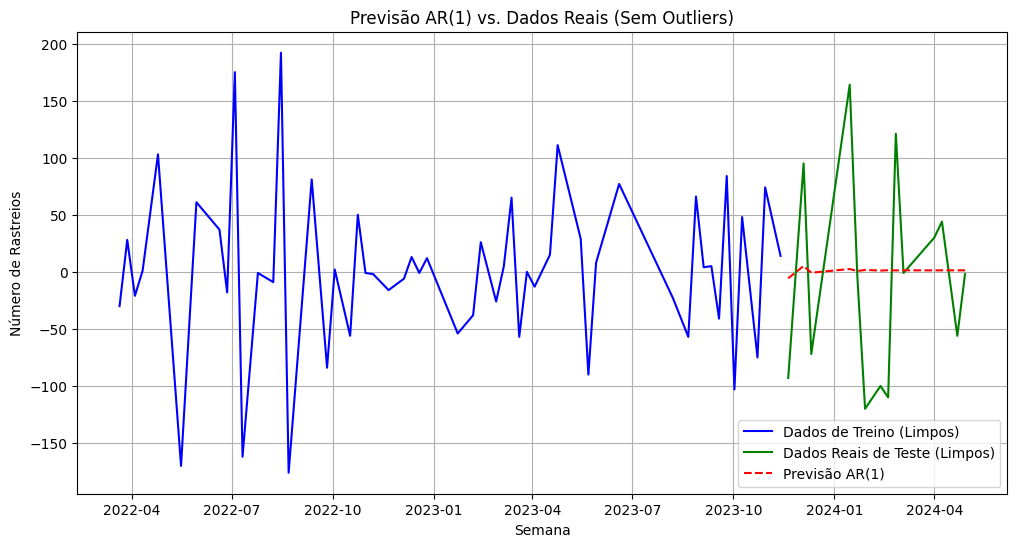

In [21]:
# 1. Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# 3. Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# 4. Criar e ajustar o modelo AR(1)
model = AutoReg(y_train, lags=1)
model_fit = model.fit()

# 5. Fazer previsões
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 6. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: AR(1) sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 7. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão AR(1)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão AR(1) vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()

# MODELO ARMA

Caso particular do ARIMA em que 'd' é 0

MODELO ARIMA MELHORES VALORES DOS PARÂMETROS

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\s

Melhor combinação de (p, d, q): (0, 0, 1) com AIC: 695.9598146886766
Modelo: ARMA
MAE: 97.53092785784263
MSE: 15723.910686853016
RMSE: 125.39501858867048
R2: 0.012580700253665311
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


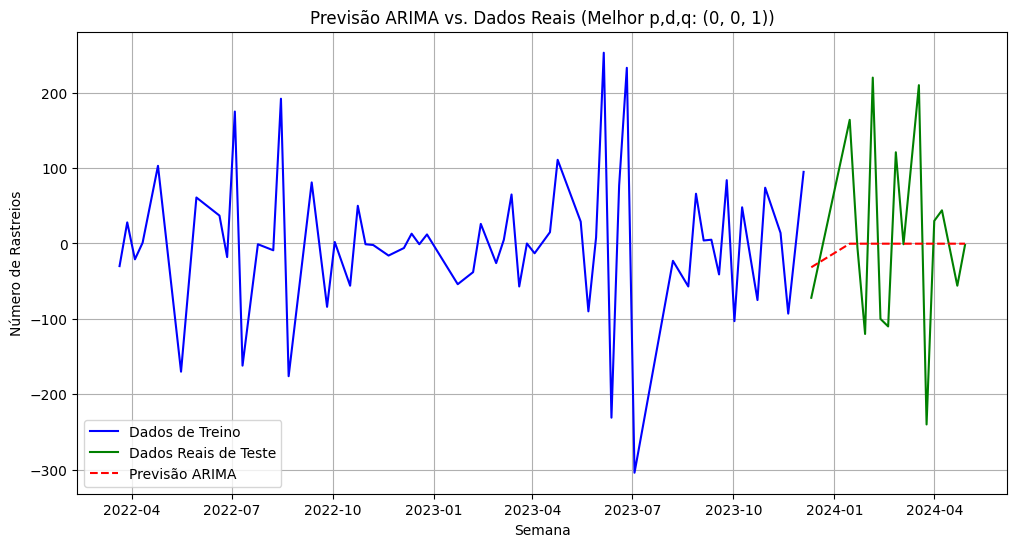

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# 1. Definir os intervalos de valores para p e q
p = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois sabemos que a série é estacionária
q = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para q

# 2. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 3. Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# 4. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 5. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 6. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 7. Avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 6. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARMA")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 8. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão ARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão ARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq})')
plt.legend()
plt.grid(True)
plt.show()

MODELO ARIMA MELHORES PARÂMETROS SEM OUTLIERS

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\s

Melhor combinação de (p, d, q): (0, 0, 1) com AIC: 593.3084676845319
Modelo: ARMA sem Outliers
MAE: 71.0909785334839
MSE: 7398.163039996652
RMSE: 86.01257489458534
R2: 0.023892464294402282
ME: nan
MAV: 72.35714285714286
MPV: nan
RME: nan
RMAE: nan


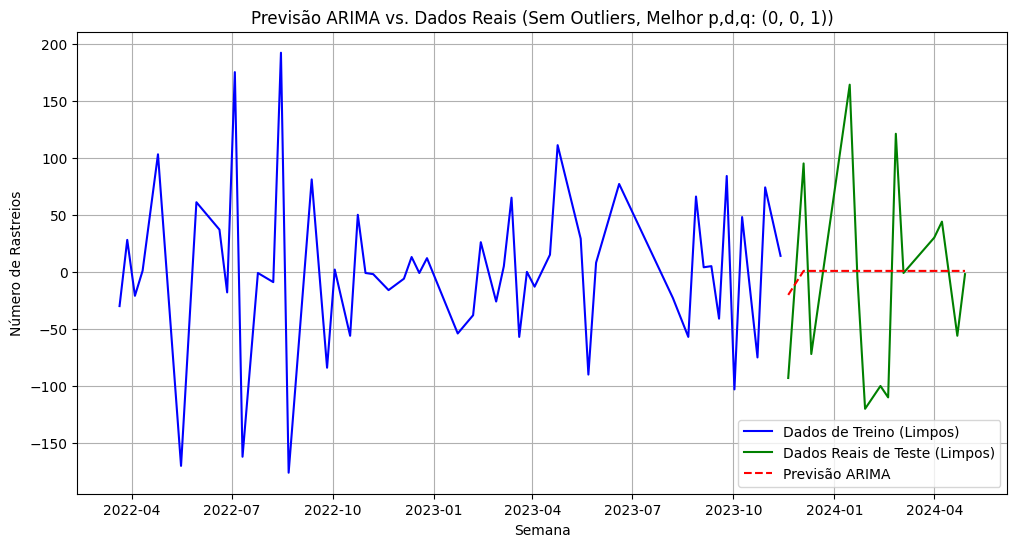

In [23]:
# 1. Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# 3. Definir os intervalos de valores para p e q
p = range(0, 4)  # Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois a série é estacionária
q = range(0, 4)  # Testar valores de 0 a 3 para q

# 4. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 5. Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# 6. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 7. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 8. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 9. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARMA sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 10. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão ARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão ARIMA vs. Dados Reais (Sem Outliers, Melhor p,d,q: {best_pdq})')
plt.legend()
plt.grid(True)
plt.show()


# MODELO SARIMA

MODELO SARIMA MELHORES PARÂMETROS

Melhor combinação de (p, d, q): (0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 4) com AIC: 660.2612554320597
Modelo: SARIMA sem Outliers
MAE: 103.11867391036867
MSE: 15381.169085111636
RMSE: 124.02084133367116
R2: 0.03410395099741159
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


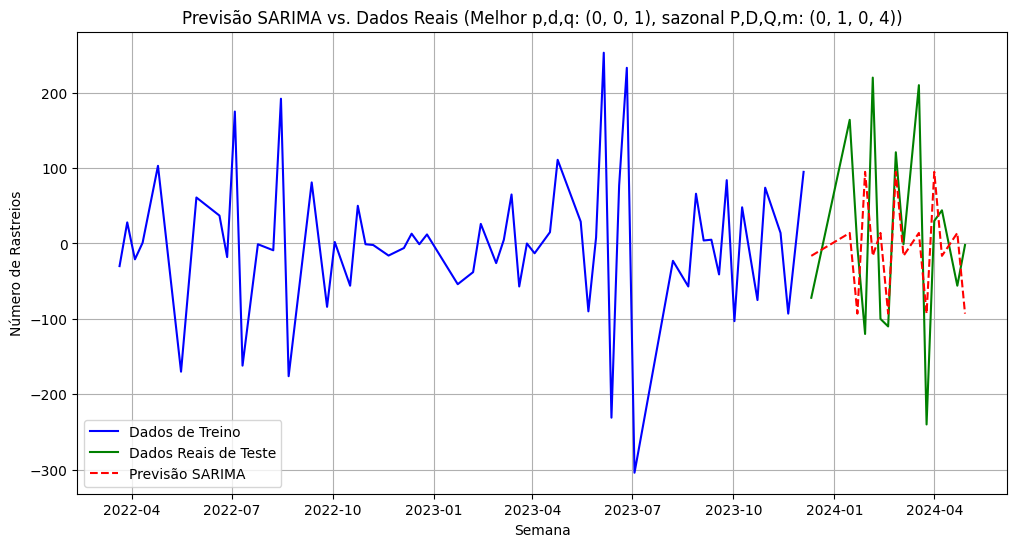

In [12]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# Definir os intervalos de valores para p, d, q, P, D, Q, e m
p = range(0, 2)
d = [0]
q = range(0, 2)
P = range(0, 1)
D = [0, 1]  # Testando tanto D=0 quanto D=1
Q = range(0, 1)
m = 4  # Sazonalidade semanal

# Criar a lista de todas as combinações possíveis de (p, d, q) e (P, D, Q, m)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# Grid Search para encontrar a melhor combinação de p, d, q, P, D, Q, m
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
                best_model = model_fit
        except:
            continue

# Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} e sazonal (P, D, Q, m): {best_seasonal_pdq} com AIC: {best_aic}")

# Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 9. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: SARIMA sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão SARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão SARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq}, sazonal P,D,Q,m: {best_seasonal_pdq})')
plt.legend()
plt.grid(True)
plt.show()

# Melhor combinação de (p, d, q): (0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 7) com AIC: 632.051832116596
# Modelo: SARIMA sem Outliers
# MAE: 139.24497401592677
# MSE: 28125.077591566034
# RMSE: 167.7053296456795
# R2: -0.7661792269015746
# ME: nan
# MAV: 99.66666666666667
# MPV: nan
# RME: nan
# RMAE: nan

# Melhor combinação de (p, d, q): (0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 4) com AIC: 660.2612554320597
# Modelo: SARIMA sem Outliers
# MAE: 103.11867391036867
# MSE: 15381.169085111636
# RMSE: 124.02084133367116
# R2: 0.03410395099741159
# ME: nan
# MAV: 99.66666666666667
# MPV: nan
# RME: nan
# RMAE: nan


MODELO SARIMA MELHOR COMBINAÇÃO DE PARÂMETROS SEM OUTLIERS

Melhor combinação de (p, d, q): (0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 4) com AIC: 660.2612554320597
Modelo: SARIMA sem Outliers
MAE: 103.11867391036867
MSE: 15381.169085111636
RMSE: 124.02084133367116
R2: 0.03410395099741159
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


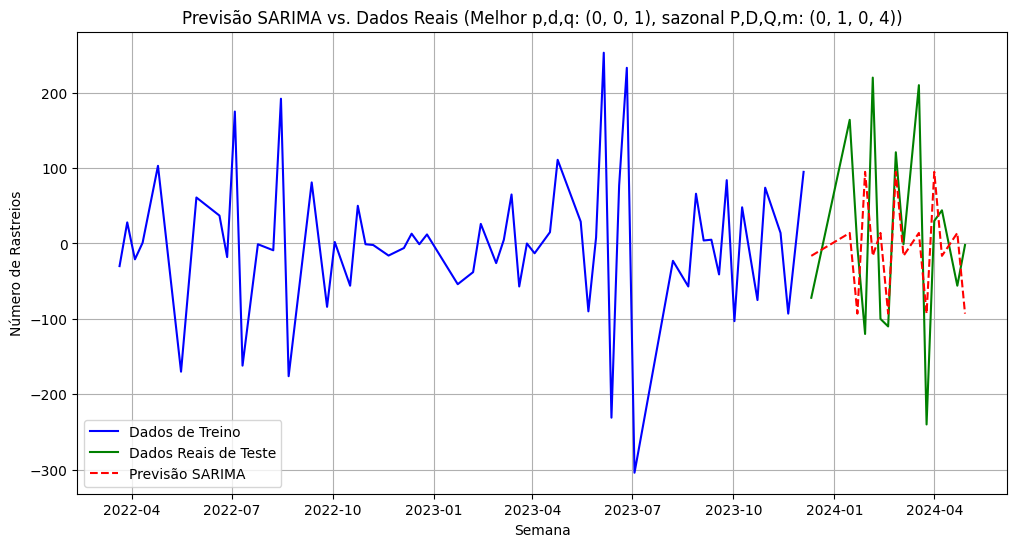

In [7]:
from scipy import stats

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# Detecção e Remoção de Outliers usando Z-score
z_scores = np.abs(stats.zscore(df_week['week_screenings']))
threshold = 3  # Definir o limiar para considerar um ponto como outlier
df_week_clean = df_week[z_scores < threshold]

# Dividir os dados em treino (80%) e teste (20%) após remover os outliers
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# Definir os intervalos de valores para p, d, q, P, D, Q, e m
p = range(0, 2)
d = [0]
q = range(0, 2)
P = range(0, 1)
D = [0, 1]  # Testando tanto D=0 quanto D=1
Q = range(0, 1)
m = 4  # Sazonalidade semanal

# Criar a lista de todas as combinações possíveis de (p, d, q) e (P, D, Q, m)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Grid Search para encontrar a melhor combinação de p, d, q, P, D, Q, m
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
                best_model = model_fit
        except:
            continue

# Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} e sazonal (P, D, Q, m): {best_seasonal_pdq} com AIC: {best_aic}")

# Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 9. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: SARIMA sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão SARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão SARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq}, sazonal P,D,Q,m: {best_seasonal_pdq})')
plt.legend()
plt.grid(True)
plt.show()

# Melhor combinação de (p, d, q): (0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 4) com AIC: 660.2612554320597
# Modelo: SARIMA sem Outliers
# MAE: 103.11867391036867
# MSE: 15381.169085111636
# RMSE: 124.02084133367116
# R2: 0.03410395099741159
# ME: nan
# MAV: 99.66666666666667
# MPV: nan
# RME: nan
# RMAE: nan

# MODELO ES

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

Simple Exponential Smoothing (SES)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo: SES
MAE: 99.81640325206509
MSE: 16059.165235071794
RMSE: 126.72476172821078
R2: -0.00847238366621128
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


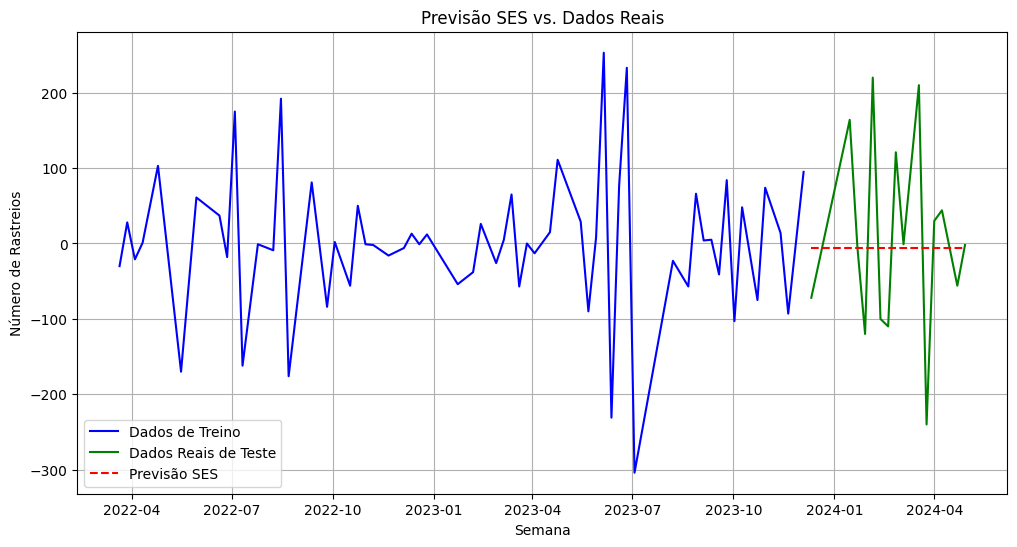

In [25]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 2. Criar e ajustar o modelo SES
model = SimpleExpSmoothing(y_train).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: SES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão SES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão SES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt’s Linear Trend Model (Double Exponential Smoothing)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo: HLTM
MAE: 99.71818029051964
MSE: 15970.990426296157
RMSE: 126.37638397381117
R2: -0.0029352428320736923
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


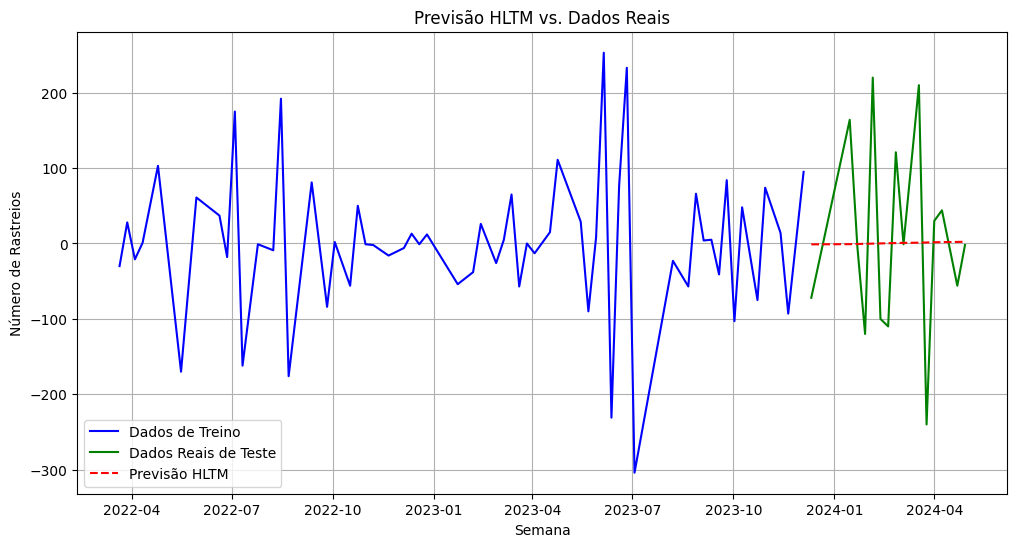

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt's Linear Trend (Double Exponential Smoothing)
model = ExponentialSmoothing(y_train, trend='add').fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HLTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão HLTM', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HLTM vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt-Winters Exponential Smoothing (Triple Exponential Smoothing)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo: HWES
MAE: 99.44446805569895
MSE: 13831.444475720426
RMSE: 117.60716166849885
R2: 0.13142248829260095
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


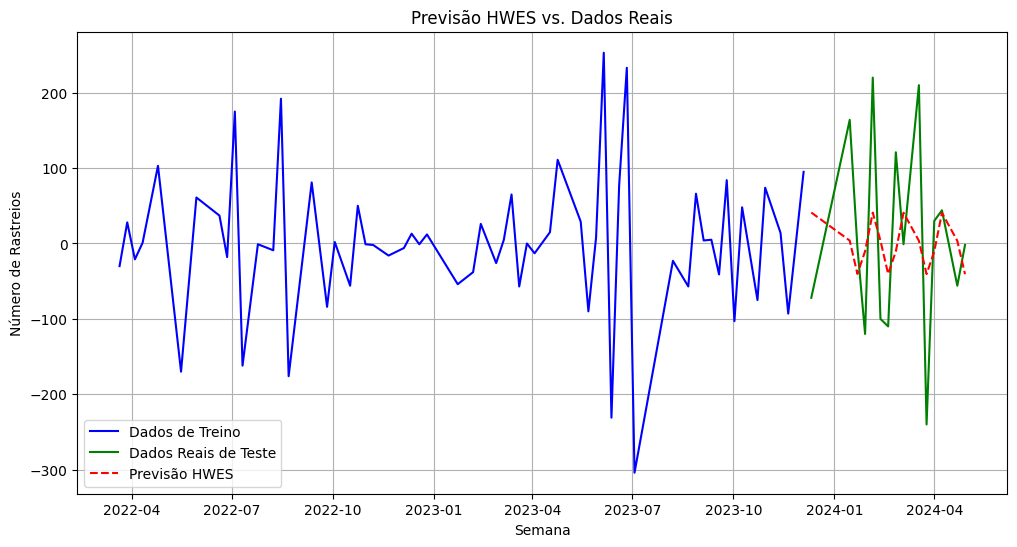

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt-Winters (Triple Exponential Smoothing)
# Definindo sazonalidade com período de 52 semanas (ajuste conforme necessário)
model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=4).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HWES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão HWES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HWES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

HWES GRID SEARCH E EXPLORAÇÃO DE PARÂMETROS

Melhor configuração encontrada: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 4, 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x000001CB826A50A0>}
Modelo: HWES otimizado
MAE: 98.69729157673625
MSE: 13242.516913659367
RMSE: 115.07613529163797
R2: 0.16840555519706146
ME: nan
MAV: 99.66666666666667
MPV: nan
RME: nan
RMAE: nan


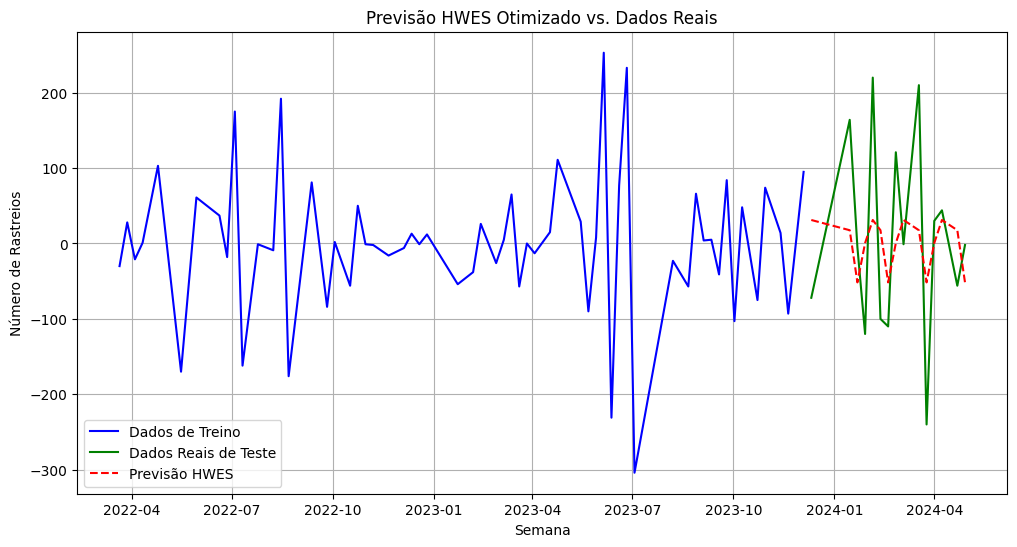

In [28]:
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# Definir os valores possíveis para tendência, sazonalidade e sazonal_periods
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods_options = [4, 12, 52]  # Ajuste conforme necessário

# Grid Search para otimizar os parâmetros
best_mae = np.inf
best_params = {}

for trend, seasonal, seasonal_periods in itertools.product(trend_options, seasonal_options, seasonal_periods_options):
    try:
        model = ExponentialSmoothing(
            y_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods
        ).fit()
        y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
        
        mae = mean_absolute_error(y_test, y_pred)
        
        if mae < best_mae:
            best_mae = mae
            best_params = {
                'trend': trend,
                'seasonal': seasonal,
                'seasonal_periods': seasonal_periods,
                'model': model
            }
    except:
        continue

# Mostrar os melhores parâmetros encontrados
print(f"Melhor configuração encontrada: {best_params}")

# Avaliar o modelo final
model = best_params['model']
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HWES otimizado")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')


# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão HWES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HWES Otimizado vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()


REMOVER OUTLIERS

In [29]:
# Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

Modelo SES: Suavização Exponencial Simples (Sem Outliers)
MAE: 72.05256083678678
MSE: 7619.800479726711
RMSE: 87.29146853918034
R2: -0.005350196883162628


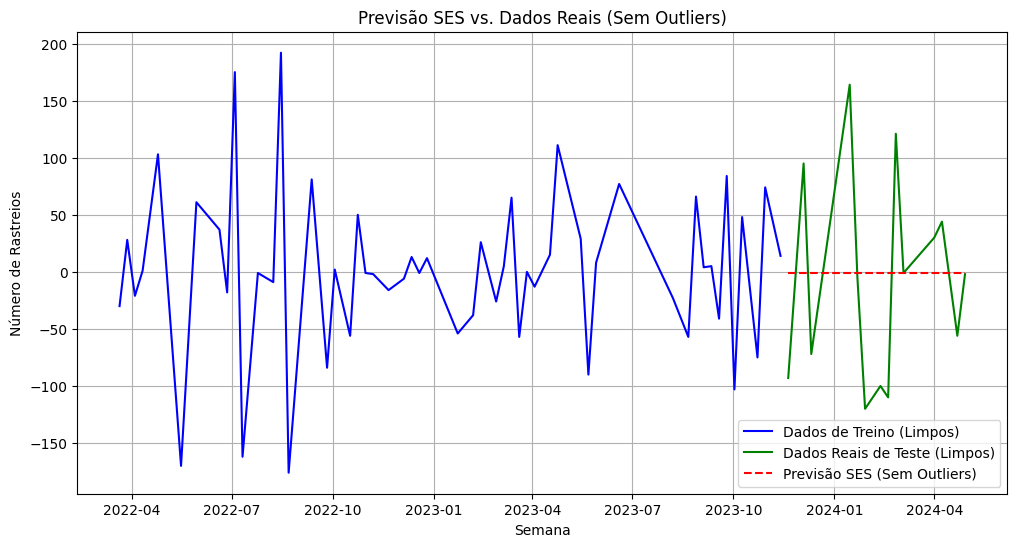

In [30]:
# Criar e ajustar o modelo SES
model_ses = SimpleExpSmoothing(y_train).fit()

# Fazer previsões
y_pred_ses = model_ses.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_ses = mean_absolute_error(y_test, y_pred_ses)
mse_ses = mean_squared_error(y_test, y_pred_ses)
rmse_ses = np.sqrt(mse_ses)
r2_ses = r2_score(y_test, y_pred_ses)

print("Modelo SES: Suavização Exponencial Simples (Sem Outliers)")
print(f'MAE: {mae_ses}')
print(f'MSE: {mse_ses}')
print(f'RMSE: {rmse_ses}')
print(f'R2: {r2_ses}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_ses, label='Previsão SES (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão SES vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()

Modelo Holt: Suavização Exponencial com Tendência Linear (Sem Outliers)
MAE: 74.21253909235523
MSE: 7773.202016343943
RMSE: 88.16576442329496
R2: -0.025589869227686357


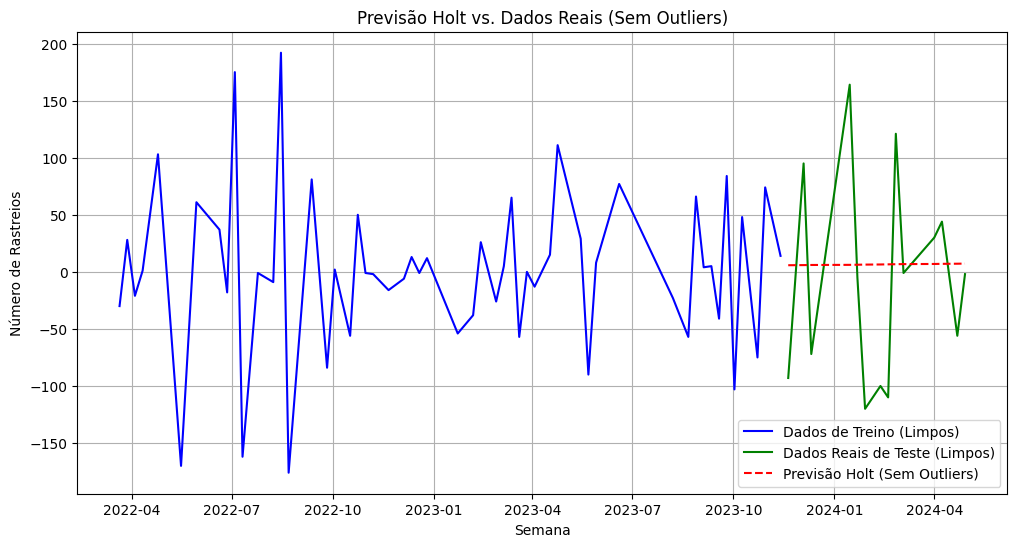

In [31]:
# Criar e ajustar o modelo Holt's Linear Trend
model_holt = ExponentialSmoothing(y_train, trend='add', seasonal=None).fit()

# Fazer previsões
y_pred_holt = model_holt.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_holt = mean_absolute_error(y_test, y_pred_holt)
mse_holt = mean_squared_error(y_test, y_pred_holt)
rmse_holt = np.sqrt(mse_holt)
r2_holt = r2_score(y_test, y_pred_holt)

print("Modelo Holt: Suavização Exponencial com Tendência Linear (Sem Outliers)")
print(f'MAE: {mae_holt}')
print(f'MSE: {mse_holt}')
print(f'RMSE: {rmse_holt}')
print(f'R2: {r2_holt}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_holt, label='Previsão Holt (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão Holt vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()


Modelo Holt-Winters: Suavização Exponencial com Sazonalidade (Sem Outliers)
MAE: 73.97999980330475
MSE: 8397.874048553891
RMSE: 91.63991514920718
R2: -0.10800858245260292


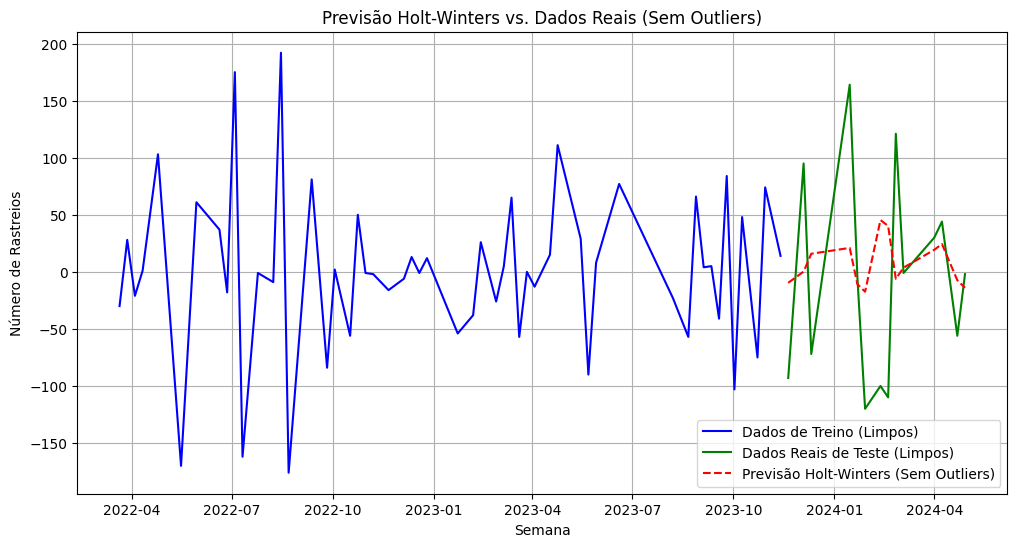

In [32]:
# Criar e ajustar o modelo Holt-Winters (Triple Exponential Smoothing)
# Usar sazonalidade com um período ajustado conforme necessário, por exemplo, 12 semanas
model_hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=8).fit()

# Fazer previsões
y_pred_hw = model_hw.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_hw = mean_absolute_error(y_test, y_pred_hw)
mse_hw = mean_squared_error(y_test, y_pred_hw)
rmse_hw = np.sqrt(mse_hw)
r2_hw = r2_score(y_test, y_pred_hw)

print("Modelo Holt-Winters: Suavização Exponencial com Sazonalidade (Sem Outliers)")
print(f'MAE: {mae_hw}')
print(f'MSE: {mse_hw}')
print(f'RMSE: {rmse_hw}')
print(f'R2: {r2_hw}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_hw, label='Previsão Holt-Winters (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão Holt-Winters vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()


Melhor configuração encontrada: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 4, 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x000001CB827EF110>}
Modelo: HWES Otimizado com Outliers Removidos
MAE: 98.69729157673625
MSE: 13242.516913659367
RMSE: 115.07613529163797
R2: 0.16840555519706146


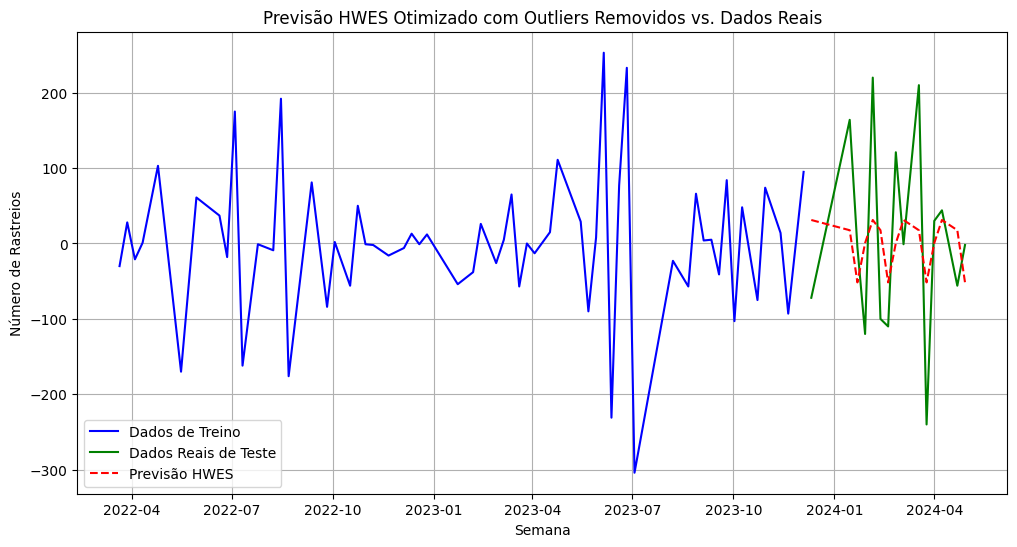

In [33]:
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# 1. Detecção e Remoção de Outliers usando Z-score
z_scores = np.abs(stats.zscore(df_week['week_screenings']))
threshold = 3  # Definir o limiar para considerar um ponto como outlier
df_week_clean = df_week[z_scores < threshold]

# Atualizar y_train e y_test após remoção de outliers
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# Definir os valores possíveis para tendência, sazonalidade e sazonal_periods
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods_options = [4, 12, 52]  # Ajuste conforme necessário

# Grid Search para otimizar os parâmetros
best_mae = np.inf
best_params = {}

for trend, seasonal, seasonal_periods in itertools.product(trend_options, seasonal_options, seasonal_periods_options):
    try:
        model = ExponentialSmoothing(
            y_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods
        ).fit()
        y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
        
        mae = mean_absolute_error(y_test, y_pred)
        
        if mae < best_mae:
            best_mae = mae
            best_params = {
                'trend': trend,
                'seasonal': seasonal,
                'seasonal_periods': seasonal_periods,
                'model': model
            }
    except:
        continue

# Mostrar os melhores parâmetros encontrados
print(f"Melhor configuração encontrada: {best_params}")

# Avaliar o modelo final
model = best_params['model']
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Modelo: HWES Otimizado com Outliers Removidos")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão HWES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HWES Otimizado com Outliers Removidos vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()
